In [381]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline
#igonre warnings
import warnings
warnings.filterwarnings("ignore")

importing cleaned data with preprocessed column 'profession' that has name of job field. dropped irrelevant features and rows with irrelevant job fields since they will produce inaccurate results

In [382]:
df = pd.read_csv('./cleaned_full_survey_data.csv')
profession_df = pd.read_csv("processed-datasets/profession_categories.csv")
df['profession'] = profession_df['Predicted_Category']
df.drop(columns=['id', 'What is your current major or job field?', 'Thank you for filling out our form! <3', 'Timestamp'], inplace=True)
df = df[df['profession'].isin(['Data Science', 'Software Development'])].copy(deep=True)
df['Which language would you recommend for someone entering your industry?'] = df['Which language would you recommend for someone entering your industry?'].astype(str)

label encoding appropriate features to be useful in extracting relationships.
qualified features had categorical data where order is important (Ordinal categories). not applicable values were kept as it is so it doesn't skew results while extracting relationships

In [383]:
label_encoder = LabelEncoder()
features_to_transform = ['Python_Community_Support',
                         'How often do you switch between these languages?',
                         'How many years of programming experience do you have?',
                         'What is your age?',
                        'Java_Community_Support',
                        'Java_Execution_Speed',
                        'R_Execution_Speed',
                        'Python_Execution_Speed',
                        'Python_Ease_of_Use',
                        'R_Ease_of_Use',
                        'Java_Ease_of_Use',
                        'Python_Documentation',
                        'Java_Documentation',
                        'Python_Concurrency_Features',
                        'Java_Concurrency_Features',
                        'Python_Readability',
                        'Java_Readability',
                        'How often do you seek help from online resources (e.g., Stack Overflow, official documentation)?'
                        ]


def label_encode_with_exceptions(series, exception='Not Applicable'):
    mask = series != exception
    encoder = LabelEncoder()
    encoded = encoder.fit_transform(series[mask])
    
    # Create a full Series with original index
    result = series.copy()
    result[mask] = encoded
    return result

for feature in features_to_transform:
    df[feature] = label_encode_with_exceptions(df[feature])
print(f"Number of transformed features: {len(features_to_transform)}")


Number of transformed features: 18


one-hot encoding was applied on features with categorical data where there is no ordering (nominal categories) while ignoring not applicable records from the result

In [384]:
# List of columns to one-hot encode
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='if_binary')
columns_to_encode = [
    'What is your gender?',
    'profession',
    'Which language would you recommend for someone entering your industry?',
    'Languages_Used',
    '  Which language do you prefer for the following tasks?   [Data Science & Machine Learning]',
    'Which language do you use most frequently?',
    'Which language do you perceive as the most efficient for your tasks?',
    '  Which language do you prefer for the following tasks?   [Web Development]',
    '  Which language do you prefer for the following tasks?   [Mobile App Development]',
    '  Which language do you prefer for the following tasks?   [Enterprise Applications]',
    '  Which language do you prefer for the following tasks?   [Statistical Analysis]',
    'Which language do you think will dominate the job market in the next 5 years?',
    'Which language was the easiest for you to learn?',
    'Which language has the most beginner-friendly documentation and learning resources?',
    'In your field, which language is the most commonly used?',
    'Which language do you believe is most in demand for jobs?',
    'Have you ever contributed to an open-source project in any of these languages?'
]

# Perform one-hot encoding
for column in columns_to_encode:
    encoded_features = one_hot_encoder.fit_transform(df[[column]]) 
    encoded_feature_names = one_hot_encoder.get_feature_names_out([column])
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(columns=[column], inplace=True)

print(f"Number of transformed features: {len(columns_to_encode)}")

Number of transformed features: 17


In [385]:
# Drop columns with 'Not Applicable' in their name
columns_to_drop = [col for col in df.columns if 'Not Applicable' in col]
df.drop(columns=columns_to_drop, inplace=True)

print(f"Dropped {len(columns_to_drop)} columns with 'Not Applicable' in their name.")

Dropped 10 columns with 'Not Applicable' in their name.


dropping free-text features since they won't add when extracting relationships

In [386]:
columns_to_drop = [
    'Have you ever had to switch from one of these languages to another due to project requirements? Why?',
    'How often do you seek help from online resources (e.g., Stack Overflow, official documentation)?',
    'If you could only use one of these three languages for all future projects, which would you choose and why?',
    'What do you think is the biggest advantage of your preferred language?',
    'What is your current role?',
    'Python_Optimization_Challenges',
    'Python_Learning_Challenges',
    'Java_Optimization_Challenges',
    'Java_Learning_Challenges',
    'Would you recommend learning another language? Why?'
]

df.drop(columns=columns_to_drop, inplace=True)

In [387]:
# Compute the correlation matrix
def calculate_correlation(feature1, feature2, data: pd.DataFrame) -> float:
    filtered = data.dropna(subset=[feature1, feature2]).copy()
    filtered[feature1] = pd.to_numeric(filtered[feature1], errors='ignore')
    filtered[feature2] = pd.to_numeric(filtered[feature2], errors='ignore')
    return filtered[feature1].corr(filtered[feature2])

# Specify the features to calculate correlation
correlation_matrix = pd.DataFrame()

df_copy = df.replace('Not Applicable', pd.NA)
for feature1 in df.columns:
    correlations = {}
    for feature2 in df.columns:
        if feature1 == feature2:
            continue  # Skip if feature1 is the same as feature2
        correlations[feature2] = calculate_correlation(feature1, feature2, df_copy)
    correlation_matrix[feature1] = pd.Series(correlations)

correlation_matrix.fillna(0, inplace=True)

In [388]:
threshold = 0.5  # Define the threshold for medium to high correlation
filtered_correlation_matrix = correlation_matrix.where(correlation_matrix.abs() >= threshold)
filtered_correlation_matrix.dropna(how='all', axis=0, inplace=True)
filtered_correlation_matrix = filtered_correlation_matrix.drop(filtered_correlation_matrix.index[0:24])
filtered_correlation_matrix.drop(filtered_correlation_matrix.index[-1], inplace=True)
filtered_correlation_matrix.dropna(how='all', axis=1, inplace=True)

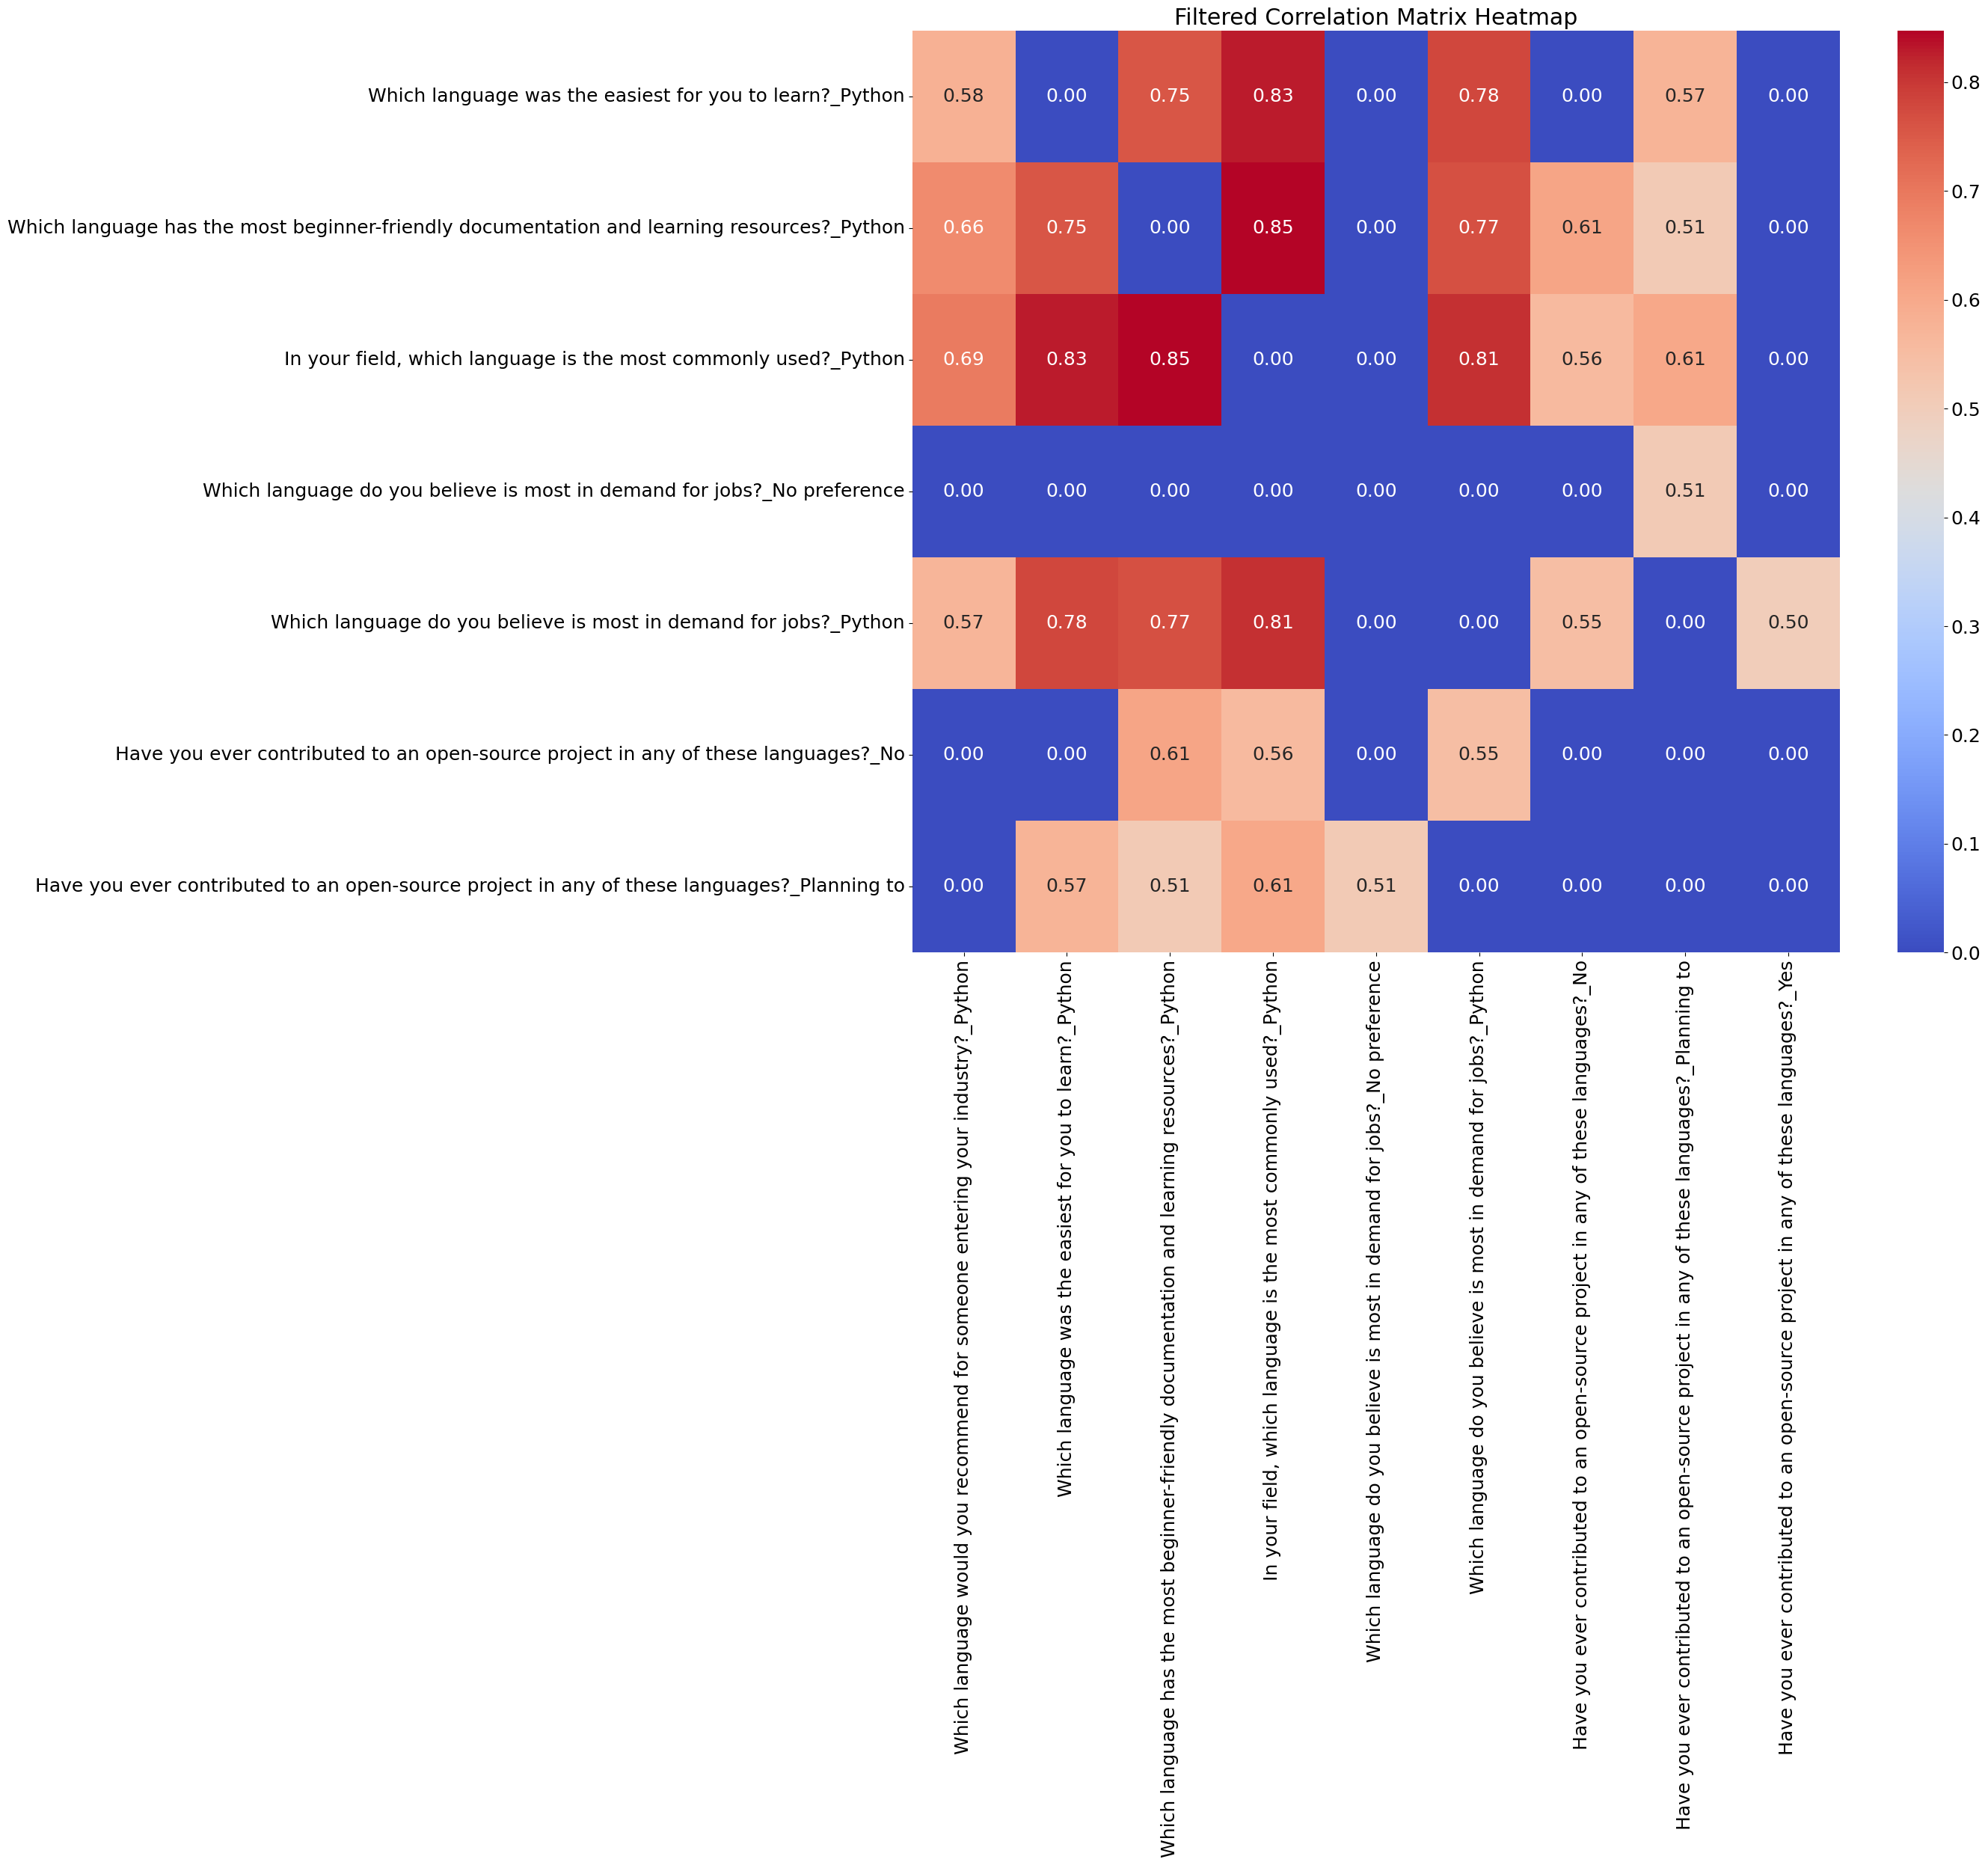

In [389]:
# Plot the heatmap
plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 18})
sns.heatmap(filtered_correlation_matrix.fillna(0), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Filtered Correlation Matrix Heatmap")
plt.show()

In [390]:
df.head()

,What is your age?,How many years of programming experience do you have?,Python_Community_Support,Java_Community_Support,R_Community_Support,R_Optimization_Challenges,R_Learning_Challenges,How often do you switch between these languages?,Python_Execution_Speed,R_Execution_Speed,Java_Execution_Speed,Python_Ease_of_Use,R_Ease_of_Use,Java_Ease_of_Use,Python_Documentation,R_Documentation,Java_Documentation,Python_Concurrency_Features,R_Concurrency_Features,Java_Concurrency_Features,Python_Readability,R_Readability,Java_Readability,What is your gender?_Male,profession_Software Development,Which language would you recommend for someone entering your industry?_Depends on the role,Which language would you recommend for someone entering your industry?_Java,Which language would you recommend for someone entering your industry?_Python,Languages_Used_Python,Which language do you prefer for the following tasks? [Data Science & Machine Learning]_Java,Which language do you prefer for the following tasks? [Data Science & Machine Learning]_Python,Which language do you prefer for the following tasks? [Data Science & Machine Learning]_R,Which language do you use most frequently?_All equally,Which language do you use most frequently?_Java,Which language do you use most frequently?_Python,Which language do you perceive as the most efficient for your tasks?_It depends,Which language do you perceive as the most efficient for your tasks?_Java,Which language do you perceive as the most efficient for your tasks?_Python,Which language do you perceive as the most efficient for your tasks?_R,Which language do you prefer for the following tasks? [Web Development]_Java,Which language do you prefer for the following tasks? [Web Development]_Python,Which language do you prefer for the following tasks? [Web Development]_R,Which language do you prefer for the following tasks? [Mobile App Development]_Java,Which language do you prefer for the following tasks? [Mobile App Development]_Python,Which language do you prefer for the following tasks? [Mobile App Development]_R,Which language do you prefer for the following tasks? [Enterprise Applications]_Java,Which language do you prefer for the following tasks? [Enterprise Applications]_Python,Which language do you prefer for the following tasks? [Enterprise Applications]_R,Which language do you prefer for the following tasks? [Statistical Analysis]_Java,Which language do you prefer for the following tasks? [Statistical Analysis]_Python,Which language do you prefer for the following tasks? [Statistical Analysis]_R,Which language do you think will dominate the job market in the next 5 years?_Java,Which language do you think will dominate the job market in the next 5 years?_Python,Which language do you think will dominate the job market in the next 5 years?_R,Which language was the easiest for you to learn?_Java,Which language was the easiest for you to learn?_Python,Which language was the easiest for you to learn?_R,Which language has the most beginner-friendly documentation and learning resources?_Java,Which language has the most beginner-friendly documentation and learning resources?_Python,Which language has the most beginner-friendly documentation and learning resources?_R,"In your field, which language is the most commonly used?_All equally","In your field, which language is the most commonly used?_Java","In your field, which language is the most commonly used?_Python",Which language do you believe is most in demand for jobs?_Java,Which language do you believe is most in demand for jobs?_No preference,Which language do you believe is most in demand for jobs?_Python,Have you ever contributed to an open-source project in any of these languages?_No,Have you ever contributed to an open-source project in any of these languages?_Planning to,Have you ever contributed to an open-source project in any of these languages?_Yes
0,0,0,3,Not Applicable,Not Applicable,Not Applicable,Not Applicable,2,1,Not Applicable,Not Applica

In [391]:
df.columns

Index(['What is your age?',
       'How many years of programming experience do you have?',
       'Python_Community_Support', 'Java_Community_Support',
       'R_Community_Support', 'R_Optimization_Challenges',
       'R_Learning_Challenges',
       'How often do you switch between these languages?',
       'Python_Execution_Speed', 'R_Execution_Speed', 'Java_Execution_Speed',
       'Python_Ease_of_Use', 'R_Ease_of_Use', 'Java_Ease_of_Use',
       'Python_Documentation', 'R_Documentation', 'Java_Documentation',
       'Python_Concurrency_Features', 'R_Concurrency_Features',
       'Java_Concurrency_Features', 'Python_Readability', 'R_Readability',
       'Java_Readability', 'What is your gender?_Male',
       'profession_Software Development',
       'Which language would you recommend for someone entering your industry?_Depends on the role',
       'Which language would you recommend for someone entering your industry?_Java',
       'Which language would you recommend for someone en

In [392]:
df_copy = df_copy.replace(pd.NA, 0)

In [393]:
df_copy.columns

Index(['What is your age?',
       'How many years of programming experience do you have?',
       'Python_Community_Support', 'Java_Community_Support',
       'R_Community_Support', 'R_Optimization_Challenges',
       'R_Learning_Challenges',
       'How often do you switch between these languages?',
       'Python_Execution_Speed', 'R_Execution_Speed', 'Java_Execution_Speed',
       'Python_Ease_of_Use', 'R_Ease_of_Use', 'Java_Ease_of_Use',
       'Python_Documentation', 'R_Documentation', 'Java_Documentation',
       'Python_Concurrency_Features', 'R_Concurrency_Features',
       'Java_Concurrency_Features', 'Python_Readability', 'R_Readability',
       'Java_Readability', 'What is your gender?_Male',
       'profession_Software Development',
       'Which language would you recommend for someone entering your industry?_Depends on the role',
       'Which language would you recommend for someone entering your industry?_Java',
       'Which language would you recommend for someone en

## Select Target

In [394]:
def get_most_used_language(row):
    if row['Which language do you use most frequently?_Python'] == 1:
        return 'Python'
    elif row['Which language do you use most frequently?_Java'] == 1:
        return 'Java'
    elif row['Which language do you use most frequently?_All equally'] == 1:
        return 'All equally'
    else:
        return 'Unknown'  

df_copy['target_language'] = df.apply(get_most_used_language, axis=1)

df_copy = df_copy[df_copy['target_language'] != 'Unknown']


## Select Features , Target

In [395]:
X = df_copy.drop(columns=[
    'Which language do you use most frequently?_Python',
    'Which language do you use most frequently?_Java',
    'Which language do you use most frequently?_All equally',
    'target_language'  
])
y = df_copy['target_language'].map({'Python': 0, 'Java': 1, 'All equally': 2})


## Apply Feature Selection

In [396]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2



bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)




featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(10,'Score'))  

X_selected = bestfeatures.transform(X)

                                                Specs     Score
9                                   R_Execution_Speed  9.671571
52  Which language was the easiest for you to lear...  7.344978
11                                 Python_Ease_of_Use  6.754914
33  Which language do you perceive as the most eff...  5.738669
14                               Python_Documentation  5.449951
3                              Java_Community_Support  5.058546
59  In your field, which language is the most comm...  4.835785
62  Which language do you believe is most in deman...  4.409843
0                                   What is your age?  4.195331
64  Have you ever contributed to an open-source pr...  4.052402


In [397]:
X = X_selected
y = df_copy['target_language'].map({'Python': 0, 'Java': 1, 'All equally': 2})

## Incressing Data To Avoid Underfitting , Imbalanced Data Probelm

In [398]:
from imblearn.under_sampling import TomekLinks
oversample = TomekLinks()
X, y = oversample.fit_resample(X, y)

## Split Our Data

In [399]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Apply All Classification Models (All Models in One Step)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
# from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

# Single Models
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier()
}

# Ensemble Models
ensemble_models = {
    'Random Forest': RandomForestClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
    # ,'XGBoost': XGBClassifier()
}


param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'Naive Bayes': {}, 
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Decision Tree': {'max_depth': [None, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200]},
    'Extra Trees': {'n_estimators': [50, 100, 200]},
    'Bagging': {'n_estimators': [10, 20, 30]},
    'AdaBoost': {'n_estimators': [50, 100, 200]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200]}
    #,'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"{name}: Best Parameters - {grid_search.best_params_}, Best Score - {grid_search.best_score_}")

for name, model in ensemble_models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"{name}: Best Parameters - {grid_search.best_params_}, Best Score - {grid_search.best_score_}")

# Voting and Stacking Models
estimators = [('rf', best_models['Random Forest']), ('SVM', best_models['SVM'])]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')  # or 'hard'
voting_clf.fit(X_train, y_train)
best_models['Voting'] = voting_clf

# Evaluate Best Models on Test Set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=4)
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{report}")


Logistic Regression: Best Parameters - {'C': 0.1}, Best Score - 0.807399577167019
KNN: Best Parameters - {'n_neighbors': 5}, Best Score - 0.807399577167019
Naive Bayes: Best Parameters - {}, Best Score - 0.20158562367864694
SVM: Best Parameters - {'C': 0.1, 'kernel': 'linear'}, Best Score - 0.807399577167019
Decision Tree: Best Parameters - {'max_depth': 5}, Best Score - 0.7752642706131079
Random Forest: Best Parameters - {'n_estimators': 100}, Best Score - 0.7706131078224102
Extra Trees: Best Parameters - {'n_estimators': 50}, Best Score - 0.7383720930232558
Bagging: Best Parameters - {'n_estimators': 30}, Best Score - 0.7429175475687103
AdaBoost: Best Parameters - {'n_estimators': 50}, Best Score - 0.751585623678647
Gradient Boosting: Best Parameters - {'n_estimators': 50}, Best Score - 0.7658562367864693
--- Logistic Regression ---
Accuracy: 0.8
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889        44
       

Now We Notice That Best Model is ***Logistic Regression*** , **SVM**  , **Decision Tree**

## Save Best Model

In [401]:
# Save the best models to a pickle file
import pickle
with open('best_models.pkl', 'wb') as f:
	pickle.dump(best_models['Logistic Regression'], f)